In [ ]:
# Importing libraries to collect and import data:
import json 
import requests 
import pickle

# Importing libraries to work with/explore data:
import pandas as pd
import numpy as np
import datetime, time
from sklearn import preprocessing

# Importing libraries to create visualizations:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import folium
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
# import itertools
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
warnings.filterwarnings('ignore')

In [ ]:
with open ('scrubbed_data_yelp_inspec.pickle','rb') as f:
    df_merged = pickle.load(f)

print(len(df_merged))
df_merged.head()

3174


,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,display_phone,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,wine_bars,womenscloth,wraps,delivery,pickup,restaurant_reservation,num_of_cat,mainstream_category,rare_category,price_value
0,50122550,& CAFE COFFEE SHOP,Manhattan,222,EAST 51 STREET,10022.0,(908) 590-3763,Coffee/Tea,2023-01-03,Violations were cited in the following area(s).,...,0,0,0,0,0,0,3,1,0,0.0
1,50126158,& SON STEAKEASY,Manhattan,62,WEST 9 STREET,10011.0,(212) 933-1193,American,2023-02-04,Violations were cited in the following area(s).,...,1,0,0,0,0,0,3,1,0,0.0
2,41430594,1 STOP PATTY SHOP,Manhattan,1708,AMSTERDAM AVENUE,10031.0,(212) 491-7466,Bakery Products/Desserts,2022-10-20,Violations were cited in the following area(s).,...,0,0,0,1,0,0,2,1,0,1.0
3,50059935,108 FOOD DRIED HOT POT,Manhattan,2794,BROADWAY,10025.0,(917) 675-6878,Chinese,2022-05-17,Violations were cited in the following area(s).,...,0,0,0,1,1,0,2,1,0,2.0
4,41092609,10TH AVENUE COOKSHOP,Manhattan,156,10 AVENUE,10011.0,(212) 924-4440,American,2022-04-11,Violations were cited in the following area(s).,...,0,0,0,1,1,0,2,1,0,2.0


In [ ]:
for i in df_merged.columns:
  print(i)

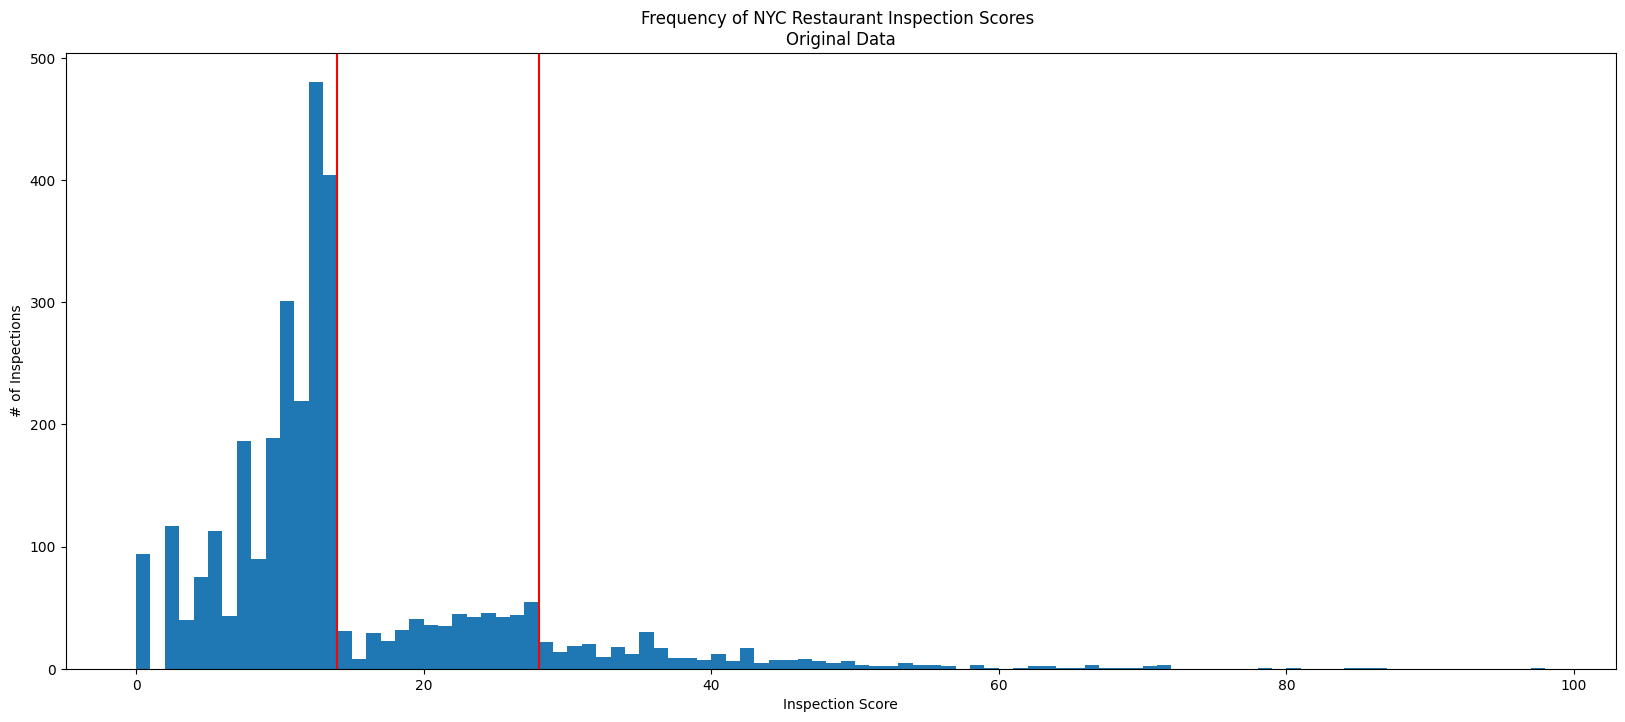

In [ ]:
def plot_grades(df, title):
    # Plot a histogram
    plt.figure(figsize=(20, 8))
    plt.hist(df['SCORE'], bins=range(int(min(df['SCORE'])), int(max(df['SCORE']))+1))
    # Add lines to indicate the cutoffs between A and B, then B and C
    plt.axvline(x=14, color="red")
    plt.axvline(x=28, color="red")
    # Add some labels
    plt.ylabel("# of Inspections")
    plt.xlabel("Inspection Score")
    plt.title("Frequency of NYC Restaurant Inspection Scores \n{}".format(title))
    return
    
plot_grades(df_merged, "Original Data")

In [ ]:
df_merged.SCORE.describe()

count    3174.000000
mean       14.238815
std        10.941799
min         0.000000
25%         9.000000
50%        12.000000
75%        14.000000
max        98.000000
Name: SCORE, dtype: float64

In [ ]:
df_merged.ZIPCODE.value_counts()

In [ ]:
df_merged["GRADE"].value_counts()

5                                                                                                                                     2195
1                                                                                                                                      797
4                                                                                                                                      137
3                                                                                                                                       39
Establishment re-opened by DOHMH.                                                                                                        5
Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.       1
Name: GRADE, dtype: int64

Next, let's look at the relationship between grades and scores, and see if it matches what we found on the Department of Health website. As a reminder, the cutoffs should be:

- A (5): 0-13
- B (4): 14-27
- C (3): 28+

In [ ]:
df_merged.groupby(["GRADE"]).agg({'SCORE': [np.min,np.max]})

SCORE      
                                                    amin  amax
GRADE                                                         
1                                                    0.0  86.0
3                                                    0.0  71.0
4                                                    9.0  36.0
5                                                    0.0  13.0
Establishment Closed by DOHMH. Violations were ...  98.0  98.0
Establishment re-opened by DOHMH.                    0.0  10.0

In [ ]:
print("Miscoded 5s: ", len(df_merged.loc[(df_merged.GRADE== 5) & (df_merged.SCORE > 13), ]))
print("Miscoded 4s: ", len(df_merged.loc[(df_merged.GRADE== 4) & ((df_merged.SCORE < 14) | (df_merged.SCORE > 27))]))
print("Miscoded 3s: ", len(df_merged.loc[(df_merged.GRADE== 3) & (df_merged.SCORE < 28), ]))


Miscoded 5s:  0
Miscoded 4s:  3
Miscoded 3s:  1


In [ ]:
df_merged.loc[(df_merged.GRADE== 4) & ((df_merged.SCORE < 14) | (df_merged.SCORE > 27))]

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,display_phone,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,wine_bars,womenscloth,wraps,delivery,pickup,restaurant_reservation,num_of_cat,mainstream_category,rare_category,price_value
275,50074726,BEETLE HOUSE,Manhattan,308,EAST 6 STREET,10003.0,(646) 510-4786,American,2020-02-11,Violations were cited in the following area(s).,...,0,0,0,1,1,1,3,1,0,3.0
1500,50091908,KRUA THAI KITCHEN,Manhattan,1764,1 AVENUE,10128.0,(646) 791-5999,Thai,2022-02-17,Violations were cited in the following area(s).,...,0,0,0,1,1,0,3,1,0,2.0
3150,40983698,YUCA BAR & RESTAURANT,Manhattan,111,AVENUE A,10009.0,(212) 982-9533,Latin American,2022-11-03,Violations were cited in the following area(s).,...,0,0,0,1,1,0,3,1,0,2.0


## Hypothesis Testing 1

In [ ]:
from scipy import stats # for significance levels and normality
import statsmodels.api as sm # for statistical exploration/testing
from statsmodels.formula.api import ols # for hypothesis testing
from statsmodels.stats.multicomp import pairwise_tukeyhsd # for pairwise comparisons
from statsmodels.stats.multicomp import MultiComparison # for multiple comparisons testing

In [ ]:
score = {1: 0, 1.5: 0, 2:0, 2.5: 0, 3: 0, 3.5:0,4:1,4.5:1,5:1}
df_merged['rating_score'] = df_merged['rating'].map(score)

# Select data needed for analysis:
high_star = df_merged[df_merged['rating_score']==1]['review_count']
low_star = df_merged[df_merged['rating_score']==0]['review_count']

# Compare mean scores of number of review for high Yelp ratings vs. low Yelp ratings:
print('High Score Mean:',high_star.mean())
print('Low Score Mean:',low_star.mean())

High Score Mean: 399.9136690647482
Low Score Mean: 321.2998137802607


In [ ]:
print('Are variances equal?:',np.var(high_star) == np.var(low_star))
print('Are sample sizes equal?:',len(high_star) == len(low_star))

Are variances equal?: False
Are sample sizes equal?: False


In [ ]:
result = stats.ttest_ind(high_star, low_star, equal_var = False) # 1-tailed Welch's t-test
print('Reject Null Hypothesis' if result[1]/2<.05 else print('Failed to Reject Null Hypothesis'))
print('t-statistic:',result[0],'p-value:',result[1]/2)

Reject Null Hypothesis
t-statistic: 5.766664527846853 p-value: 4.455606915244771e-09


We end up with a very low p-value that is less than our alpha value of .05. This value is statistically significant and gives a strong case against our null hypothesis. Therefore, we would reject our null hypothesis and say that having a high Yelp rating does lead to a greater number of reviews being written compared to restaurants with low ratings.  


In [ ]:
def Cohen_d(group1, group2):
    '''This function takes in two groups of data and calculates the Cohen's d value between them.'''

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [ ]:
Cohen_d(high_star,low_star)

0.19016885047345125

Small effect on the number of reviews

## Hypothesis 2

In [ ]:
# Select only data that has an actual inspection grade of A, B, or C.
df_merged_temp = df_merged.loc[df_merged['GRADE'].isin([5,4,3])].copy()

# Select data needed for analysis:
high_grade = df_merged_temp[df_merged_temp['GRADE']== 5]['review_count']
low_grade = df_merged_temp[df_merged_temp['GRADE']!= 5]['review_count']

# Compare mean scores of number of reviews for high Yelp ratings vs. low Yelp ratings:
print('High Grade Mean:',high_grade.mean())
print('Low Grade Mean:',low_grade.mean())

High Grade Mean: 383.8232346241458
Low Grade Mean: 341.9431818181818


In [ ]:
# Test whether variances and sample size are equal:
print('Are variances equal?:',np.var(high_grade) == np.var(low_grade))
print('Are sample sizes equal?:',len(high_grade) == len(low_grade))

Are variances equal?: False
Are sample sizes equal?: False


In [ ]:
result2 = stats.ttest_ind(high_grade, low_grade, equal_var = False) # 1-tailed Welch's t-test
print('Reject Null Hypothesis' if result2[1]/2<.05 else print('Failed to Reject Null Hypothesis'))
print('t-statistic:',result2[0],'p-value:',result2[1]/2)

Reject Null Hypothesis
t-statistic: 1.6921641647982297 p-value: 0.04594956376902698


Meaningful relationship between Number of Yelp reviews and Grade

In [ ]:
Cohen_d(high_grade,low_grade)

0.09472896252308152

## Hypothesis 3

In [ ]:
df_merged.rename(columns={'CUISINE DESCRIPTION': 'CUISINE_DESCRIPTION'}, inplace=True)

# Perform 2-sided ANOVA test. Use C() when working with categorical data
formula1 = 'review_count ~ C(CUISINE_DESCRIPTION)'
lm1 = ols(formula1, df_merged).fit()
result1 = sm.stats.anova_lm(lm1, typ=2)
print(result1)

                              sum_sq      df         F        PR(>F)
C(CUISINE_DESCRIPTION)  2.889472e+07    74.0  2.340062  1.413331e-09
Residual                5.171076e+08  3099.0       NaN           NaN


In [ ]:
mc1 = MultiComparison(df_merged['review_count'], df_merged['CUISINE_DESCRIPTION'])
mc1_results = mc1.tukeyhsd()

# Convert results to a dataframe:
tukey_data1 = pd.DataFrame(data=mc1_results._results_table.data[1:], columns = mc1_results._results_table.data[0])

# Select only rows where we are rejecting the null hypothesis:
tukey_data1 = tukey_data1.loc[tukey_data1['reject']==True]
tukey_data1

,group1,group2,meandiff,p-adj,lower,upper,reject
966,Chicken,Italian,271.4662,0.0311,7.8712,535.0613,True
970,Chicken,Korean,417.2023,0.0004,85.2115,749.1932,True
989,Chicken,Sandwiches,437.9792,0.0028,61.4066,814.5517,True
1025,Chinese,Italian,171.8218,0.0021,25.9384,317.7053,True
1029,Chinese,Korean,317.5579,0.0003,68.5247,566.5912,True
1048,Chinese,Sandwiches,338.3348,0.0083,32.3830,644.2866,True
1196,Coffee/Tea,Italian,230.9037,0.0080,22.4902,439.3172,True
1200,Coffee/Tea,Korean,376.6398,0.0002,86.5161,666.7635,True
1219,Coffee/Tea,Sandwiches,397.4167,0.0025,57.1804,737.6529,True
2193,Korean,Pizza,-286.7605,0.0121,-551.0394,-22.4815,True


In [ ]:
def multi_cohen_d(values_list, data_column, value, column_label1, column_label2):
    '''This function will evaluate Cohen's d between multiple identified pairs of data.
    Inputs:
        - values_list: list containing lists of each pair of values to evaluate
        - data_column: column from full dataset that is used to match with the data in values_list 
        - value: column from full dataset that includes the actual data values you want to extract
        - column_label1: label for the column of the dataframe we are creating that includes group1
        - column_label2: label for the column of the dataframe we are creating that includes group2
    
    Returns:
        - A dataframe listing the components of each group and the corresponding Cohen's d'''
    
    d = pd.DataFrame(columns = [column_label1,column_label2,"Cohen's d"], index = None)
    for x in values_list:
        cohen = Cohen_d(df_merged[df_merged[data_column]==x[0]][value],
                        df_merged[df_merged[data_column]==x[1]][value])
        d = d.append({column_label1:x[0],column_label2:x[1], "Cohen's d":cohen}, ignore_index=True)
    return d

# Identify the values we want to utilize to find Cohen's d:
cuisine_list = tukey_data1.loc[tukey_data1['reject']==True].iloc[:,:2].values.tolist()

# Run function to see all Cohen's d values:
print("Cohen's d Chart:")
multi_cohen_d(cuisine_list, 'CUISINE_DESCRIPTION', 'review_count','Cuisine1', 'Cuisine2')

Cohen's d Chart:


,Cuisine1,Cuisine2,Cohen's d
0,Chicken,Italian,-0.902856
1,Chicken,Korean,-1.312161
2,Chicken,Sandwiches,-0.271692
3,Chinese,Italian,-0.561518
4,Chinese,Korean,-1.001086
5,Chinese,Sandwiches,-0.359970
6,Coffee/Tea,Italian,-0.782089
7,Coffee/Tea,Korean,-1.263127
8,Coffee/Tea,Sandwiches,-0.293388
9,Korean,Pizza,0.890661


## Hypothesis 4

In [ ]:
# Select data needed for analysis:
high_price = df_merged[df_merged['price_value']== (4 or 3)]['review_count']
low_price = df_merged[df_merged['rating_score']!= (4 or 3)]['review_count']

# Compare mean scores of number of review for high Yelp ratings vs. low Yelp ratings:
print('High Score Mean:',high_price.mean())
print('Low Score Mean:',low_price.mean())

High Score Mean: 554.232
Low Score Mean: 371.42281033396347


In [ ]:
print('Are variances equal?:',np.var(high_price) == np.var(low_price))
print('Are sample sizes equal?:',len(high_price) == len(low_price))

Are variances equal?: False
Are sample sizes equal?: False


In [ ]:
result3 = stats.ttest_ind(high_price, low_price, equal_var = False) # 1-tailed Welch's t-test
print('Reject Null Hypothesis' if result3[1]/2<.05 else print('Failed to Reject Null Hypothesis'))
print('t-statistic:',result[0],'p-value:',result3[1]/2)

Reject Null Hypothesis
t-statistic: 5.766664527846853 p-value: 2.3626271571972953e-08


In [ ]:
Cohen_d(high_price,low_price)

0.4433273791402817

Hypothesis 5

In [ ]:
rare_cat = df_merged[df_merged['rare_category']== 1]['review_count']
not_rare_cat = df_merged[df_merged['rare_category']!= 1]['review_count']

# Compare mean scores of number of review for high Yelp ratings vs. low Yelp ratings:
print('High Score Mean:',rare_cat.mean())
print('Low Score Mean:',not_rare_cat.mean())

High Score Mean: 368.4429824561403
Low Score Mean: 371.92273730684326


In [ ]:
print('Are variances equal?:',np.var(rare_cat) == np.var(not_rare_cat))
print('Are sample sizes equal?:',len(rare_cat) == len(not_rare_cat))

Are variances equal?: False
Are sample sizes equal?: False


In [ ]:
result4 = stats.ttest_ind(rare_cat,not_rare_cat, equal_var = False) # 1-tailed Welch's t-test
print('Reject Null Hypothesis' if result4[1]/2<.05 else print('Failed to Reject Null Hypothesis'))
print('t-statistic:',result[0],'p-value:',result4[1]/2)

Failed to Reject Null Hypothesis
None
t-statistic: 5.766664527846853 p-value: 0.4206777884956818
